In [5]:
# Import libraries

from pyspark.sql import SparkSession

from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
import pandas as pd

In [6]:
# Create SparkSession

spark = SparkSession.builder.appName('Demand Prediction').getOrCreate()

from pyspark.sql.functions import col

In [7]:
# Load data

# 1.Aggregate data
data = spark.read.format("csv").option("header", "true").load("data/Aggregate/daily_demand_totals.csv")

# 2.Concrete data
# data = spark.read.format("csv").option("header", "true").load("data/Concrete/daily_demand_totals.csv")

In [8]:
# Convert the 'demand' column to a numeric type
data = data.withColumn("demand", col("demand").cast("double"))

# Data cleaning and preparation
data = data.dropna()
data = data.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))
data = data.withColumn("year", year(col("timestamp")))
data = data.withColumn("month", month(col("timestamp")))
data = data.withColumn("day", dayofmonth(col("timestamp")))

In [9]:
# consider more human common sense

data = data.withColumn("day_of_week", dayofweek(col("timestamp")))
data = data.withColumn("is_weekend", when(col("day_of_week").isin([1, 7]), 1).otherwise(0))

In [10]:
# Feature engineering

assembler = VectorAssembler(inputCols=["year", "month", "day", "day_of_week", "is_weekend"], outputCol="features")
data = assembler.transform(data)

In [11]:
# Divide the dataset into training and testing sets
(train_data, test_data) = data.randomSplit([0.7, 0.3], seed=100)

# Data Exploration

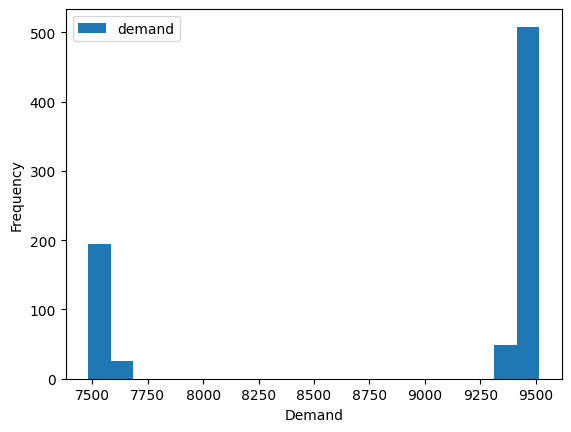

In [17]:
# Draw a histogram of demand

demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='hist', bins=20)
plt.xlabel('Demand')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


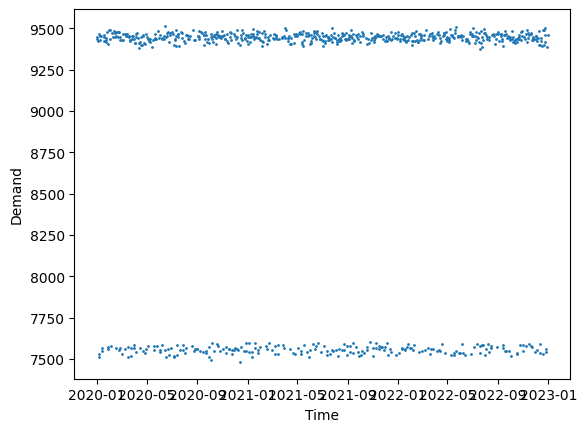

In [18]:
# Draw a scatterplot of demand and time

data = train_data.select('timestamp', 'demand').toPandas()
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.plot(x='timestamp', y='demand', kind='scatter', s=1)
plt.xlabel('Time')
plt.ylabel('Demand')
plt.show()

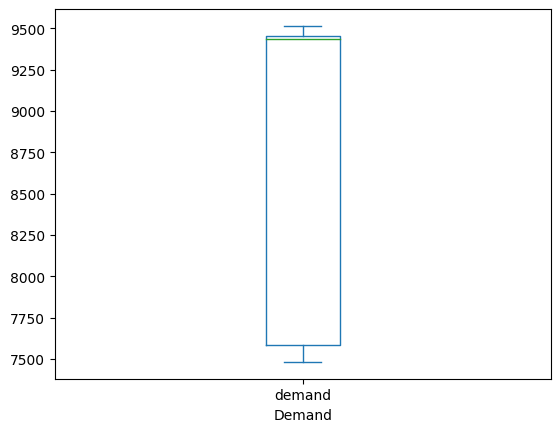

In [19]:
# Use Boxplot to detect outliers and the shape of data distribution

demand = pd.DataFrame(train_data.select('demand').rdd.map(lambda x: x[0]).collect(), columns=['demand'])
demand.plot(kind='box')
plt.xlabel('Demand')
plt.show()

# Model Training and Prediction

## 1. Linear Regression

In [21]:
# Define Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="demand", regParam=0.01)

# Training model
lr_model = lr.fit(train_data)

# Predict future demand
predictions = lr_model.transform(test_data)

# Calculate the evaluation metric of the model (mean squared error)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output mean square error
print("Mean Squared Error (MSE) on test data = %g" % mse)


+----+-----+---+-----------+----------+------+------------------+
|year|month|day|day_of_week|is_weekend|demand|        prediction|
+----+-----+---+-----------+----------+------+------------------+
|2020|    1|  4|          7|         1|9454.0|10087.444530790175|
|2020|    1| 11|          7|         1|9420.0|10064.694969686278|
|2020|    1| 12|          1|         1|9447.0|  8870.76416530273|
|2020|    1| 15|          4|         0|9465.0|  8708.86880296442|
|2020|    1| 16|          5|         0|9420.0|  8904.06567684436|
|2020|    1| 20|          2|         0|7573.0| 8295.725494100638|
|2020|    1| 21|          3|         0|7581.0| 8490.922367980582|
|2020|    1| 26|          1|         1|9426.0| 8825.265043094934|
|2020|    1| 30|          5|         0|9446.0| 8858.566554636565|
|2020|    2|  4|          3|         0|7535.0| 8541.194102269734|
|2020|    2|  5|          4|         0|9425.0| 8736.390976149674|
|2020|    2|  7|          6|         0|9446.0| 9126.784723909559|
|2020|    

## 2. Redom Forest Regression

In [22]:
# Create a Random Forest Regression Model
rf = RandomForestRegressor(featuresCol="features", labelCol="demand", numTrees=10)

# Training model
rf_model = rf.fit(train_data)

# Predict future demand
predictions = rf_model.transform(test_data)

# Calculate the evaluation metric of the model (mean squared error)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output mean square error
print("Mean Squared Error (MSE) on test data = %g" % mse)


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9445.976147186148|
|2020|    1| 11|          7|         1|9420.0| 9448.68889640193|
|2020|    1| 12|          1|         1|9447.0|9453.789108622546|
|2020|    1| 15|          4|         0|9465.0|9341.038167024668|
|2020|    1| 16|          5|         0|9420.0| 9343.45396067546|
|2020|    1| 20|          2|         0|7573.0|7827.275302955665|
|2020|    1| 21|          3|         0|7581.0|7829.151258838018|
|2020|    1| 26|          1|         1|9426.0|9445.645237891755|
|2020|    1| 30|          5|         0|9446.0|9448.770135225885|
|2020|    2|  4|          3|         0|7535.0|7702.778747107399|
|2020|    2|  5|          4|         0|9425.0|9334.221763325246|
|2020|    2|  7|          6|         0|9446.0|9336.898461660929|
|2020|    2|  8|         

## 3. Gradient Boosted Tree Regression

In [23]:
# Create a Gradient Boosted Tree Regression Model
gbt = GBTRegressor(featuresCol="features", labelCol="demand", maxIter=10)

# Training model
gbt_model = gbt.fit(train_data)

# Predict future demand
predictions = gbt_model.transform(test_data)

# Calculate the evaluation metric of the model (mean squared error)
evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)

# Show prediction results
predictions.select("year", "month", "day", "day_of_week", "is_weekend", "demand", "prediction").show()

# Output mean square error
print("Mean Squared Error (MSE) on test data = %g" % mse)


+----+-----+---+-----------+----------+------+-----------------+
|year|month|day|day_of_week|is_weekend|demand|       prediction|
+----+-----+---+-----------+----------+------+-----------------+
|2020|    1|  4|          7|         1|9454.0|9451.535132010034|
|2020|    1| 11|          7|         1|9420.0| 9465.03487660728|
|2020|    1| 12|          1|         1|9447.0|9435.635496037023|
|2020|    1| 15|          4|         0|9465.0|9463.241857995656|
|2020|    1| 16|          5|         0|9420.0|9454.673274596578|
|2020|    1| 20|          2|         0|7573.0|7557.852397988255|
|2020|    1| 21|          3|         0|7581.0|7559.108337341195|
|2020|    1| 26|          1|         1|9426.0|  9444.7290418998|
|2020|    1| 30|          5|         0|9446.0|9441.272686670985|
|2020|    2|  4|          3|         0|7535.0|7561.709267554762|
|2020|    2|  5|          4|         0|9425.0|9443.881852761118|
|2020|    2|  7|          6|         0|9446.0|9435.494182912302|
|2020|    2|  8|         

In [24]:
# Prediction using three different models
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the predictive performance of each model using mean squared error
lr_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
lr_mse = lr_evaluator.evaluate(lr_predictions)
rf_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
rf_mse = rf_evaluator.evaluate(rf_predictions)
gbt_evaluator = RegressionEvaluator(labelCol="demand", predictionCol="prediction", metricName="mse")
gbt_mse = gbt_evaluator.evaluate(gbt_predictions)

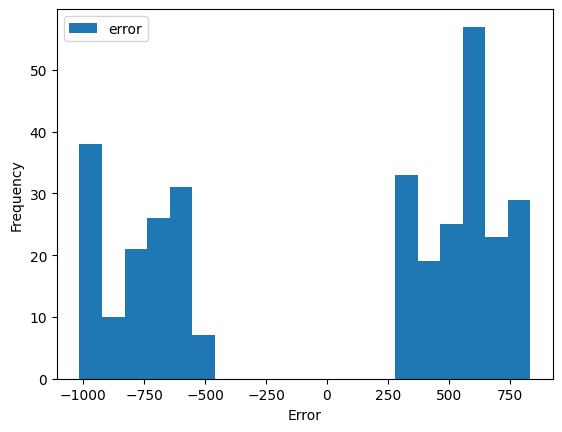

In [25]:
# Select lr_model as an example, and use the prediction error distribution chart to observe whether the prediction error of the model conforms to the normal distribution

# Calculate prediction error
lr_predictions = lr_model.transform(test_data)
lr_errors = lr_predictions.select("demand", "prediction").rdd.map(lambda x: x[0] - x[1]).collect()

# Plotting the distribution of prediction error
pd.DataFrame(lr_errors, columns=['error']).plot(kind='hist', bins=20)
plt.xlabel('Error')
plt.show()

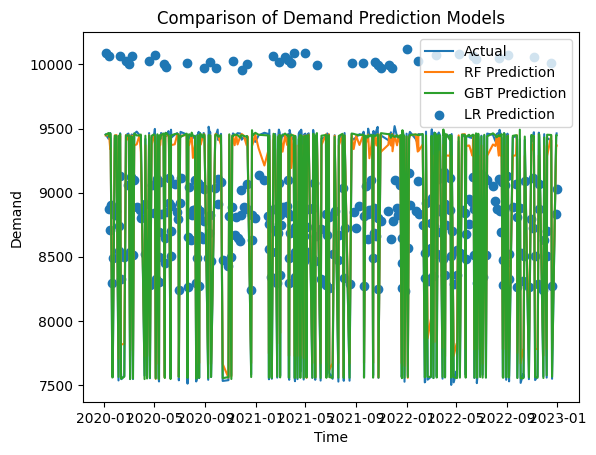

Linear Regression Mean Squared Error (MSE) on test data = 455801
Random Forest Mean Squared Error (MSE) on test data = 15965.4
Gradient Boosted Tree Mean Squared Error (MSE) on test data = 651.349


In [26]:
# Create an array of time series
time_series = test_data.select("timestamp").rdd.flatMap(lambda x: x).collect()

# Create a matplotlib chart and plot the actual demand and predictions from each model
fig, ax = plt.subplots()
ax.plot(time_series, test_data.select("demand").collect(), label="Actual")
ax.plot(time_series, rf_predictions.select("prediction").collect(), label="RF Prediction")
ax.plot(time_series, gbt_predictions.select("prediction").collect(), label="GBT Prediction")
ax.scatter(time_series, lr_predictions.select("prediction").collect(), label="LR Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("Demand")
ax.set_title("Comparison of Demand Prediction Models")
ax.legend()

# Show the chart
plt.show()

# Output evaluation results
print("Linear Regression Mean Squared Error (MSE) on test data = %g" % lr_mse)
print("Random Forest Mean Squared Error (MSE) on test data = %g" % rf_mse)
print("Gradient Boosted Tree Mean Squared Error (MSE) on test data = %g" % gbt_mse)


In [27]:
print('In the visualization chart of prediction results, the prediction results of the random forest regression \
model and the gradient boosted tree regression model are closer to the actual demand value than that of the linear \
regression model, and the gradient boosted tree regression model is the model with the smallest mean square error, \
which is selected as the final inventory predictive model')

In the visualization chart of prediction results, the prediction results of the random forest regression model and the gradient boosted tree regression model are closer to the actual demand value than that of the linear regression model, and the gradient boosted tree regression model is the model with the smallest mean square error, which is selected as the final inventory predictive model
